In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [2]:
pickle_file = 'small_321_train.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['small_data']
    train_labels = save['small_target']
    del save  # hint to help gc free up memory
    print('train set', train_dataset.shape, train_labels.shape)

train set (750, 1, 64, 64) (750, 6)


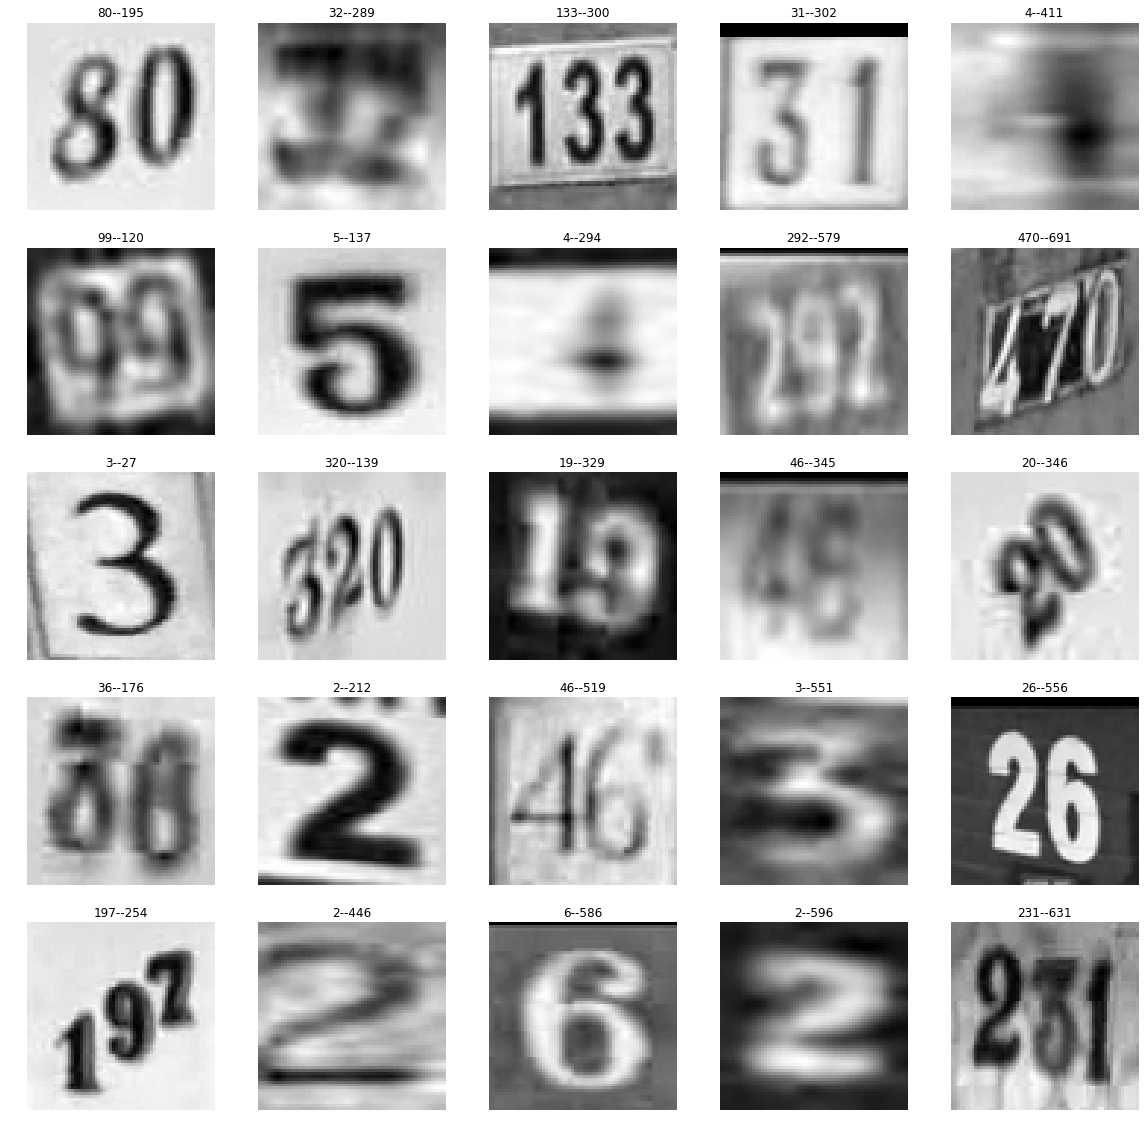

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=5, ncols=5)

im_samples = []

for row in range(5):
    for i, j in enumerate(np.sort(np.random.randint(0, train_labels.shape[0], size=5))):
        im = train_dataset[j].reshape((64, 64, 1))
        house_num = ''
        for k in np.arange(train_labels[j,0]):
            house_num += str(train_labels[j,k+1])
        house_num += "--" + str(j)
        im_samples.extend([j])
        ax[row, i].axis('off')
        ax[row, i].set_title(house_num, loc='center')
        ax[row, i].imshow(im[:,:,0], cmap='gray')

In [12]:
ims1 = [157, 184, 436, 478, 40, 613, 350]
ims2 = [383, 260, 14, 389, 531, 495, 270]
ims3 = [139, 630, 341, 454, 532]

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 40, 3, padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 80, 3, padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(80)
        self.conv4 = nn.Conv2d(80, 120, 3, padding=(1, 1))
        self.bn4 = nn.BatchNorm2d(120)
        self.conv5 = nn.Conv2d(120, 160, 3, padding=(1, 1))
        self.bn5 = nn.BatchNorm2d(160)
        self.conv6 = nn.Conv2d(160, 200, 3, padding=(1, 1))
        self.bn6 = nn.BatchNorm2d(200)
        self.conv7 = nn.Conv2d(200, 240, 3, padding=(1, 1))
        self.bn7 = nn.BatchNorm2d(240)
        self.pool = nn.MaxPool2d(2, 2)
        self.FC = nn.Linear(960, 1080)
        self.bn8 = nn.BatchNorm1d(1080)
        self.digitlength = nn.Linear(1080, 7)
        self.digit1 = nn.Linear(1080, 10)
        self.digit2 = nn.Linear(1080, 10)
        self.digit3 = nn.Linear(1080, 10)
        self.digit4 = nn.Linear(1080, 10)
        self.digit5 = nn.Linear(1080, 10)
        self.image = None
        
    def forward(self, X):
        self.image = X
        x = self.image
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.pool(self.bn6(F.relu(self.conv6(x))))
        x = self.pool(self.bn7(F.relu(self.conv7(x))))
        x = x.view(-1, 960)
        x = self.bn8(F.relu(self.FC(x)))
        yl = self.digitlength(x)
        y1 = self.digit1(x)
        y2 = self.digit2(x)
        y3 = self.digit3(x)
        y4 = self.digit4(x)
        y5 = self.digit5(x)
        return [yl, y1, y2, y3, y4, y5]

In [6]:
net = Net()
f = open('what_now.pkl', 'rb')
net.load_state_dict(torch.load(f))
f.close()
net.cuda()
print("!")

!


In [7]:
for param in net.parameters():
    if(param.grad is not None):
        print(param)

In [8]:
print(net.image)

None


In [9]:
net.eval()
print("!")

!


In [10]:
def compute_saliency_maps(X, Y, net):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, of shape (N, 1, H, W)
    - Y: Labels for X, of shape (N, 6)
    - net: A PretrainedCNN that will be used to compute the saliency map.

    Returns:
    - saliency: An array of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    N, xx, H, W = X.shape
    saliency = np.zeros((N, H, W))
    
    ##############################################################################
    # TODO: Implement this function. You should use the forward and backward     #
    # methods of the PretrainedCNN class, and compute gradients with respect to  #
    # the unnormalized class score of the ground-truth classes in y.             #
    ##############################################################################
    Xt = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda(), requires_grad=True)
    scores = net(Xt)
    #len
    shape = (N, 7)
    d_len = np.zeros(shape)
    d_len[np.arange(N), 1] = 1
    d_len = torch.from_numpy(d_len).type(torch.FloatTensor).cuda()
    
    #dig1
    shape = (N, 10)
    d_dig1 = np.zeros(shape)
    d_dig1[np.arange(N), Y[:, 1]] = 1
    d_dig1 = torch.from_numpy(d_dig1).type(torch.FloatTensor).cuda()
    
    #dig2
    shape = (N, 10)
    d_dig2 = np.zeros(shape)
    d_dig2[np.arange(N), Y[:, 2]] = 1
    d_dig2 = torch.from_numpy(d_dig2).type(torch.FloatTensor).cuda()
    
    #dig3
    shape = (N, 10)
    d_dig3 = np.zeros(shape)
    d_dig3[np.arange(N), Y[:, 3]] = 1
    d_dig3 = torch.from_numpy(d_dig3).type(torch.FloatTensor).cuda()
    
    net.zero_grad()
    #scores[1].backward(d_dig1)
    #scores[2].backward(d_dig2)
    scores[3].backward(d_dig3)
    dX = net.image
    dX = dX.grad.data.cpu().numpy()
    
    dX = np.abs(dX)
    
    saliency = dX
        
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

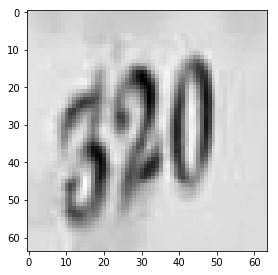

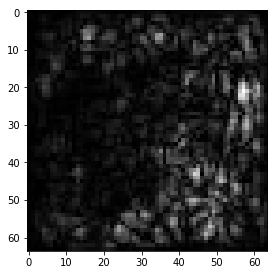

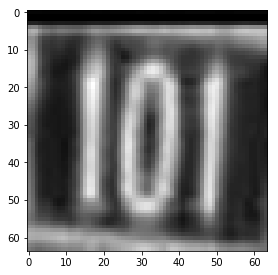

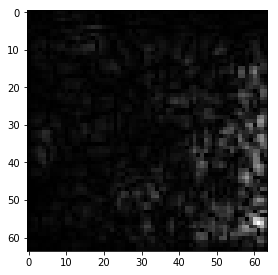

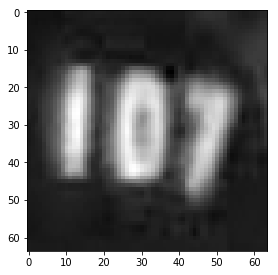

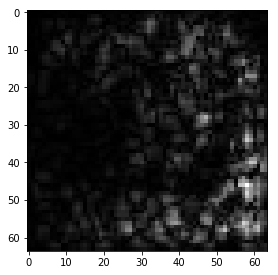

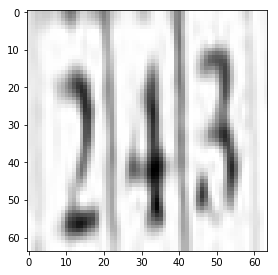

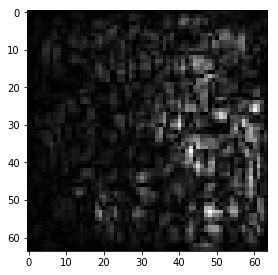

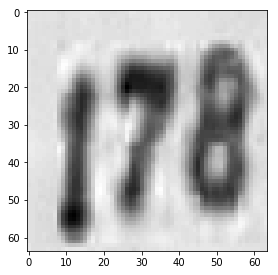

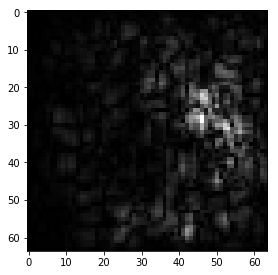

In [13]:
def show_saliency_maps(mask):
    mask = np.asarray(mask)
    X = train_dataset[mask]
    y = train_labels[mask]
    saliency = compute_saliency_maps(X, y, net)
    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        im = X[i].reshape((64, 64, 1))
        plt.imshow(im[:,:,0], cmap='gray')
        plt.gcf().set_size_inches(25, 25)
        plt.show()
        plt.subplot(2, mask.size, mask.size + i + 1)
        sal = saliency[i].reshape((64, 64, 1))
        plt.imshow(sal[:,:,0], cmap='gray')
        plt.gcf().set_size_inches(25, 25)
        plt.show()
  
# These are some cherry-picked images that should give good results
show_saliency_maps(ims3)

In [11]:
a = Variable(torch.randn(3, 4)).cuda()
print(tuple(a.size()))

(3, 4)


In [30]:
b = Variable(torch.randn(3, 4)).cuda()

In [31]:
c = torch.cat([a, b], 1)

In [23]:
b = a.data.cpu().numpy()

In [16]:
print(np.zeros((2, 2)))

[[ 0.  0.]
 [ 0.  0.]]
